# Single cell analysis

In [1]:
# try:
#     import varseek as vk
# except ImportError:
#     print("varseek not found, installing...")
#     !pip install -U -q varseek
# try:
#     import RLSRWP_2025
# except ImportError:
#     print("RLSRWP_2025 not found, installing...")
#     !pip install -q git+https://github.com/pachterlab/RLSRWP_2025.git
# try:
#     import gget
# except ImportError:
#     print("gget not found, installing...")
#     !pip install -U -q gget

In [2]:
import os
import anndata as ad
import pandas as pd
import gget
import subprocess
import ast
import numpy as np
import matplotlib.pyplot as plt
import varseek as vk
from RLSRWP_2025.constants import box_links_dict

RLSRWP_2025_dir = os.path.dirname(os.path.abspath(""))  # if this notebook resides in RLSRWP_2025/notebooks/0_data_download.ipynb, then this retrieves RLSRWP_2025

In [ ]:
number_cbio_samples = 10
custom_genes = ["EGFR", "SOX9", "NFIB"]  # genes beyond what I identify in cbioportal

vk_count_out_dir = os.path.join(RLSRWP_2025_dir, "data", "vk_count_out_fig1")
adata_path = os.path.join(vk_count_out_dir, "adata_cleaned.h5ad")
adata_reference_genome_path = os.path.join(vk_count_out_dir, "adata_reference_genome_cleaned.h5ad")

out_dir = os.path.join(vk_count_out_dir, "analysis", "single_cell_analysis")

cbioportal_mutated_genes_path = os.path.join(out_dir, "Mutated_Genes.txt")
gbm_metadata_path = os.path.join(out_dir, "GBM_metadata.csv")
gbm_metadata_sra_path = os.path.join(RLSRWP_2025_dir, "data", "glioblastoma_smartseq_fastq_data", "SraRunTable.csv")

reference_dir = os.path.join(RLSRWP_2025_dir, "data", "reference")
cosmic_csv = os.path.join(reference_dir, "cosmic", "CancerMutationCensus_AllData_Tsv_v101_GRCh37", "CancerMutationCensus_AllData_v101_GRCh37_mutation_workflow.csv")
cosmic_cgc_path = os.path.join(reference_dir, "cosmic", "Cosmic_CancerGeneCensus_Tsv_v101_GRCh37", "Cosmic_CancerGeneCensus_v101_GRCh37.tsv")
sequences_cds = os.path.join(reference_dir, "ensembl_grch37_release93", "Homo_sapiens.GRCh37.cds.all.fa")
sequences_cdna = os.path.join(reference_dir, "ensembl_grch37_release93", "Homo_sapiens.GRCh37.cdna.all.fa")

Download data

In [4]:
if not os.path.isfile(adata_path):
    vk.utils.download_box_url(box_links_dict["glioblastoma_smartseq_adata_vcrs"], output_file_name=adata_path)
if not os.path.isfile(adata_reference_genome_path):
    vk.utils.download_box_url(box_links_dict["glioblastoma_smartseq_adata_reference_genome"], output_file_name=adata_reference_genome_path)
if not os.path.isfile(cosmic_csv):
    vk.utils.download_box_url(box_links_dict["cosmic_csv"], output_file_name=cosmic_csv)
if not os.path.isfile(cosmic_cgc_path):
    vk.utils.download_box_url(box_links_dict["cosmic_cgc"], output_file_name=cosmic_cgc_path)
if not os.path.isfile(gbm_metadata_path):
    vk.utils.download_box_url(box_links_dict["gbm_metadata"], output_file_name=gbm_metadata_path)
if not os.path.isfile(cbioportal_mutated_genes_path):
    vk.utils.download_box_url(box_links_dict["cbioportal_mutated_genes"], output_file_name=cbioportal_mutated_genes_path)
if not os.path.isfile(gbm_metadata_sra_path):
    vk.utils.download_box_url(box_links_dict["gbm_metadata_sra"], output_file_name=gbm_metadata_sra_path)

os.makedirs(out_dir, exist_ok=True)

In [5]:
adata = ad.read_h5ad(adata_path)
adata_reference_genome = ad.read_h5ad(adata_reference_genome_path)

cosmic_df = pd.read_csv(cosmic_csv)
cosmic_cgc_df = pd.read_csv(cosmic_cgc_path, sep="\t")
metadata_df = pd.read_csv(gbm_metadata_path, sep=" ")
cbioportal_mutated_genes_df = pd.read_csv(cbioportal_mutated_genes_path, sep="\t")
metadata_df_sra = pd.read_csv(gbm_metadata_sra_path)

In [6]:
adata.var.head()

,vcrs_id,vcrs_header,seq_ID,mutation_cdna,nucleotide_positions,actual_variant,start_variant_position,end_variant_position,variant_source,gene_name,vcrs_header_with_gene_name,vcrs_count,vcrs_detected,gene_count,number_obs
variant,,,,,,,,,,,,,,,
ENST00000391429:c.194C>T,ENST00000391429:c.194C>T,ENST00000391429:c.194C>T,ENST00000391429,c.194C>T,194,C>T,194.0,194.0,transcriptome,ENSG00000205899,ENSG00000205899(ENST00000391429):c.194C>T,0.0,False,0,0
ENST00000391429:c.128C>A,ENST00000391429:c.128C>A,ENST00000391429:c.128C>A,ENST00000391429,c.128C>A,128,C>A,128.0,128.0,transcriptome,ENSG00000205899,ENSG00000205899(ENST00000391429):c.128C>A,0.0,False,0,0
ENST00000391429:c.257C>A,ENST00000391429:c.257C>A,ENST00000391429:c.257C>A,ENST00000391429,c.257C>A,257,C>A,257.0,257.0,transcriptome,ENSG00000205899,ENSG00000205899(ENST00000391429):c.257C>A,0.0,False,0,0
ENST00000391429:c.100G>A,ENST00000391429:c.100G>A,ENST00000391429:c.100G>A,ENST00000391429,c.100G>A,100,G>A,100.0,100.0,transcriptome,ENSG00000205899,ENSG00000205899(ENST00000391429):c.100G>A,0.0,False,0,0
ENST00000391429:c.99G>A,ENST00000391429:c.99G>A,ENST00000391429:c.99G>A,ENST00000391429,c.99G>A,99,G>A,99.0,99.0,transcriptome,ENSG00000205899,ENSG00000205899(ENST00000391429):c.99G>A,0.0,False,0,0


In [7]:
cosmic_df.head()

,seq_ID,mutation,mutation_aa,gene_name,mutation_id,mutation_cdna,header
0,ENST00000396153,c.1468C>T,p.Q490*,FAF1,48293736,c.1920C>T,ENST00000396153:c.1920C>T
1,ENST00000396153,c.711G>T,p.W237C,FAF1,48304295,c.1163G>T,ENST00000396153:c.1163G>T
2,ENST00000396153,c.1548C>T,p.R516=,FAF1,48302907,c.2000C>T,ENST00000396153:c.2000C>T
3,ENST00000396153,c.429del,p.G144Afs*13,FAF1,48291600,c.881del,ENST00000396153:c.881del
4,ENST00000396153,c.797G>A,p.G266E,FAF1,48301048,c.1249G>A,ENST00000396153:c.1249G>A


In [8]:
cosmic_cgc_df.head()

,GENE_SYMBOL,NAME,COSMIC_GENE_ID,CHROMOSOME,GENOME_START,GENOME_STOP,CHR_BAND,SOMATIC,GERMLINE,TUMOUR_TYPES_SOMATIC,TUMOUR_TYPES_GERMLINE,CANCER_SYNDROME,TISSUE_TYPE,MOLECULAR_GENETICS,ROLE_IN_CANCER,MUTATION_TYPES,TRANSLOCATION_PARTNER,OTHER_GERMLINE_MUT,OTHER_SYNDROME,TIER,SYNONYMS
0,A1CF,APOBEC1 complementation factor,COSG46891,10,52559169.0,52645435.0,10q11.23,y,n,melanoma,NaN,NaN,E,NaN,oncogene,Mis,NaN,n,NaN,2,"A1CF,ENSG00000148584.10,Q9NQ94,29974,ACF,ACF64..."
1,ABI1,abl interactor 1,COSG5120,10,27035522.0,27150016.0,10p12.1,y,n,AML,NaN,NaN,L,Dom,"TSG, fusion",T,KMT2A,n,NaN,1,"ABI1,ENSG00000136754.12,Q8IZP0,10006,ABI-1,E3B1"
2,ABL1,"ABL proto-oncogene 1, non-receptor tyrosine ki...",COSG4968,9,133589333.0,133763062.0,9q34.12,y,n,"CML, ALL, T-ALL",NaN,NaN,L,Dom,"oncogene, fusion","T, Mis","BCR, ETV6, NUP214",n,NaN,1,"ABL1,ENSG00000097007.13,P00519,25,JTK7,c-ABL,p150"
3,ABL2,"ABL proto-oncogene 2, non-receptor tyrosine ki...",COSG36573,1,179068462.0,179198819.0,1q25.2,y,n,AML,NaN,NaN,L,Dom,"oncogene, fusion",T,ETV6,n,NaN,1,"ABL2,ENSG00000143322.15,P42684,27,ARG"
4,ACKR3,atypical chemokine receptor 3,COSG38910,2,237476430.0,237491001.0,2q37.3,y,n,lipoma,NaN,NaN,M,Dom,"oncogene, fusion",T,HMGA2,n,NaN,1,"ACKR3,ENSG00000144476.5,P25106,57007,GPR159,RDC1"


In [9]:
cbioportal_mutated_genes_df = cbioportal_mutated_genes_df.sort_values(by="#", ascending=False)
cbioportal_mutated_genes_df.head()

,Gene,MutSig(Q-value),# Mut,#,Profiled Samples,Freq,Is Cancer Gene (source: OncoKB)
3608,PTEN,NaN,138,133,397,33.5%,Yes
10720,TP53,NaN,149,125,397,31.5%,Yes
7725,TTN,NaN,202,101,397,25.4%,No
12205,EGFR,NaN,117,94,397,23.7%,Yes
5513,MUC16,NaN,103,61,397,15.4%,No


In [35]:
metadata_df.head()

,Sample.type,Selection,Location,Sample.name,Total_reads,Unique_reads,Unique_reads_percent,Splice_sites_total,Splice_sites_Annotated,Splice_sites_GT.AG,Splice_sites_GC.AG,Splice_sites_AT.AC,Splice_sites_non_canonical,Multimapping_reads_percent,Unmapped_mismatch,Unmapped_short,Unmapped_other,ERCC_reads,Non_ERCC_reads,ERCC_to_non_ERCC,Genes_detected,housekeeping_cluster,housekeeping_cluster_color,Sample.type.color,Selection.color,Sample.name.color,Location.color,Cluster_2d,Cluster_2d_color
1001000173.G8,Glioblastoma,Unpanned,Tumor,BT_S2,1741039,1400382,80.43,126660,122397,125741,761,102,56,2.67,2.15,14.56,0.18,152104,270429,0.562454,1962,2,#AEC7E8,#1F77B4,#98DF8A,#AEC7E8,#FF7F0E,11,#8C564B
1001000173.D4,Glioblastoma,Unpanned,Tumor,BT_S2,1229919,1081271,87.91,106857,103763,105878,683,203,93,0.84,0.59,10.66,0.00,244319,169375,1.442474,515,2,#AEC7E8,#1F77B4,#98DF8A,#AEC7E8,#FF7F0E,2,#AEC7E8
1001000173.B4,Glioblastoma,Unpanned,Tumor,BT_S2,1483293,1301500,87.74,539234,531827,536121,2380,406,327,4.02,1.06,7.09,0.06,42559,727429,0.058506,5607,2,#AEC7E8,#1F77B4,#98DF8A,#AEC7E8,#FF7F0E,11,#8C564B
1001000173.A2,Glioblastoma,Unpanned,Tumor,BT_S2,1943210,1678256,86.37,469261,457505,465354,3105,355,447,2.95,1.31,9.23,0.13,106559,705661,0.151006,3856,2,#AEC7E8,#1F77B4,#98DF8A,#AEC7E8,#FF7F0E,11,#8C564B
1001000173.E2,Glioblastoma,Unpanned,Tumor,BT_S2,1968898,1656225,84.12,204141,195729,202753,1249,31,108,3.05,1.58,11.01,0.20,136919,390799,0.350357,2173,2,#AEC7E8,#1F77B4,#98DF8A,#AEC7E8,#FF7F0E,11,#8C564B


In [11]:
metadata_df_sra['experiment_name'] = metadata_df_sra["plate_id"].astype(str) + "." + metadata_df_sra["well"].astype(str)
metadata_df_sra.head()

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,cell_type,Center Name,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,diagnosis,Experiment,GEO_Accession (exp),Instrument,LibraryLayout,LibrarySelection,LibrarySource,neoplastic,Organism,Patient_ID,plate_id,Platform,ReleaseDate,Sample Name,Selection,source_name,SRA Study,tissue,tsne_cluster,well,create_date,version,experiment_name
0,SRR3934349,RNA-Seq,128,223967101,PRJNA330719,SAMN05421106,85578803,Neoplastic,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",glioblastoma,SRX1963641,GSM2243439,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Neoplastic,Homo sapiens,BT_S2,1001000173,ILLUMINA,2017-11-02T00:00:00Z,GSM2243439,Unpanned,Brain,SRP079058,Tumor,11,G8,2016-07-20T23:14:00Z,1.0,1001000173.G8
1,SRR3934350,RNA-Seq,128,158226652,PRJNA330719,SAMN05421107,60181027,Oligodendrocyte,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",glioblastoma,SRX1963642,GSM2243440,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Regular,Homo sapiens,BT_S2,1001000173,ILLUMINA,2017-11-02T00:00:00Z,GSM2243440,Unpanned,Brain,SRP079058,Tumor,2,D4,2016-07-20T23:13:00Z,1.0,1001000173.D4
2,SRR3934351,RNA-Seq,128,190712697,PRJNA330719,SAMN05421108,72386867,Neoplastic,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",glioblastoma,SRX1963643,GSM2243441,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Neoplastic,Homo sapiens,BT_S2,1001000173,ILLUMINA,2017-11-02T00:00:00Z,GSM2243441,Unpanned,Brain,SRP079058,Tumor,11,B4,2016-07-20T23:10:00Z,1.0,1001000173.B4
3,SRR3934352,RNA-Seq,128,249900053,PRJNA330719,SAMN05421109,95698536,Neoplastic,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",glioblastoma,SRX1963644,GSM2243442,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Neoplastic,Homo sapiens,BT_S2,1001000173,ILLUMINA,2017-11-02T00:00:00Z,GSM2243442,Unpanned,Brain,SRP079058,Tumor,11,A2,2016-07-20T23:10:00Z,1.0,1001000173.A2
4,SRR3934353,RNA-Seq,128,253252958,PRJNA330719,SAMN05421110,96374384,Neoplastic,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",glioblastoma,SRX1963645,GSM2243443,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Neoplastic,Homo sapiens,BT_S2,1001000173,ILLUMINA,2017-11-02T00:00:00Z,GSM2243443,Unpanned,Brain,SRP079058,Tumor,11,E2,2016-07-20T23:14:00Z,1.0,1001000173.E2


## Data cleaning

In [ ]:
adata = adata[:, np.array((adata.X != 0).sum(axis=0)).flatten() > 0]  # Identify columns (variants) with non-zero counts across samples
adata = adata[:, ~adata.var_names.str.contains(";")]  # Identify columns (variants) with semicolon in name
adata.var = adata.var.drop(columns=["vcrs_id", "vcrs_detected", "variant_source"])  # drop vcrs_id (because it is a duplicate of vcrs_header)
adata.var = adata.var.rename(columns={"vcrs_header": "variant_name", "gene_name": "gene_id", "vcrs_header_with_gene_name": "variant_name_with_gene_id", "vcrs_count": "variant_count"})
adata.var = adata.var.merge(cosmic_df[["seq_ID", "gene_name"]].drop_duplicates("seq_ID"), on="seq_ID", how="left").rename(columns={"gene_name": "gene_symbol"})

adata.var["VAF"] = adata.var["number_obs"] / adata.shape[0]  # fraction of cells with variant

adata.var['variant_name_with_gene_name'] = (
    adata.var["gene_symbol"] + "(" +
    adata.var["variant_name"].str.split(":").str[0] + "):" +
    adata.var["variant_name"].str.split(":").str[1]
)

adata.var = adata.var.merge(cosmic_cgc_df[["GENE_SYMBOL", "TUMOUR_TYPES_SOMATIC", "TUMOUR_TYPES_GERMLINE", "ROLE_IN_CANCER"]], left_on="gene_symbol", right_on="GENE_SYMBOL", how="left")
adata.var = adata.var.drop(columns=["GENE_SYMBOL"])

# reorder columns in adata.var
priority_cols = [
    "variant_name",
    "gene_symbol",
    "variant_count",
    "gene_count",
    "number_obs",
    "VAF",
    "ROLE_IN_CANCER",
    "TUMOUR_TYPES_SOMATIC",
    "TUMOUR_TYPES_GERMLINE",
]

# Get the remaining columns not in the priority list
remaining_cols = [col for col in adata.var.columns if col not in priority_cols]

# Reorder adata.var
adata.var = adata.var[priority_cols + remaining_cols]

adata.obs.index = adata.obs.index.astype(str)  # avoid Don’t call _normalize_index with non-categorical/string names
adata.var.index = adata.var.index.astype(str)  # avoid Don’t call _normalize_index with non-categorical/string names

In [16]:
# Filter to keep only rows where "#" is >= number_cbio_samples
cbioportal_mutated_genes_df_top = cbioportal_mutated_genes_df[cbioportal_mutated_genes_df["#"] >= number_cbio_samples]

In [17]:
# only keep columns of adata where adata.var['gene_symbol'] is in cbioportal_mutated_genes_df['Gene'].unique()
gbm_genes = set(cbioportal_mutated_genes_df_top['Gene'].unique())
gbm_genes.update(custom_genes)
adata = adata[:, adata.var['gene_symbol'].isin(gbm_genes)]

## From their paper, Fig2a

In [18]:
cluster_color_to_identity_dict = {
    "1": "Neoplastic cells 1",  # cluster 1 from picture (counting from top left, going down and the across)
    "2": "Oligodendrocytes",  # cluster 10 from picture
    "3": "Vascular cells 1",  # cluster 4
    "4": "Neoplastic cells 2",  # cluster 2
    "5": "Neurons",  # cluster 9
    "6": "Vascular cells 2",  # cluster 5
    "7": "Myeloid cell 1",  # cluster 7
    "8": "Myeloid cell 2",  # cluster 8
    "9": "OPCs",  # cluster 11
    "10": "Astrocytes",  # cluster 12
    "11": "Neoplastic cells 3",  # cluster 3
    "12": "Vascular cells 3",  # cluster 6
}

metadata_df[['Cluster_2d', 'Cluster_2d_color']].drop_duplicates().sort_values('Cluster_2d')

,Cluster_2d,Cluster_2d_color
1001000175.F12,1,#1F77B4
1001000173.D4,2,#AEC7E8
1001000175.B6,3,#FF7F0E
1001000258.F11,4,#FFBB78
1001000175.H9,5,#2CA02C
1001000031.C5,6,#98DF8A
1001000173.D11,7,#D62728
1001000173.B6,8,#FF9896
1001000173.D6,9,#9467BD
1001000180.G9,10,#C5B0D5


In [19]:
kb_info_json_path = os.path.join(vk_count_out_dir, "kb_count_out_vcrs", "kb_info.json")

import json
import re
from collections import OrderedDict

# Load the JSON
with open(kb_info_json_path) as f:
    kb_info = json.load(f)

# Extract the call string
call_str = kb_info["call"]

# Find all .fastq file paths (ending in .fastq or .fastq.gz if needed)
fastq_files = re.findall(r'\S+\.fastq(?:\.gz)?', call_str)

fastq_file_bases = [os.path.basename(fastq_file).split("_")[0] for fastq_file in fastq_files]
unique_fastq_bases = list(OrderedDict.fromkeys(fastq_file_bases))  # remove duplicates while preserving order 
adata.obs['Run'] = unique_fastq_bases

In [20]:
adata.obs = adata.obs.reset_index().merge(metadata_df_sra[["Run", "experiment_name", "cell_type", "neoplastic", "Patient_ID", "tissue", "tsne_cluster"]], on="Run", how="left").rename(columns={"cell_type": "cell_type_sra"}).set_index('barcode')
adata.obs["cell_type"] = adata.obs["tsne_cluster"].astype(str).map(cluster_color_to_identity_dict)
adata.obs["cell_type_broad"] = adata.obs["cell_type"].apply(lambda x: x.rsplit(" ", 1)[0])

In [21]:
adata.obs.head()

,Run,experiment_name,cell_type_sra,neoplastic,Patient_ID,tissue,tsne_cluster,cell_type,cell_type_broad
barcode,,,,,,,,,
AAAAAAAAAAAAAAAA,SRR3934349,1001000173.G8,Neoplastic,Neoplastic,BT_S2,Tumor,11,Neoplastic cells 3,Neoplastic cells
AAAAAAAAAAAAAAAC,SRR3934350,1001000173.D4,Oligodendrocyte,Regular,BT_S2,Tumor,2,Oligodendrocytes,Oligodendrocytes
AAAAAAAAAAAAAAAG,SRR3934351,1001000173.B4,Neoplastic,Neoplastic,BT_S2,Tumor,11,Neoplastic cells 3,Neoplastic cells
AAAAAAAAAAAAAAAT,SRR3934352,1001000173.A2,Neoplastic,Neoplastic,BT_S2,Tumor,11,Neoplastic cells 3,Neoplastic cells
AAAAAAAAAAAAAACA,SRR3934353,1001000173.E2,Neoplastic,Neoplastic,BT_S2,Tumor,11,Neoplastic cells 3,Neoplastic cells


### The original manuscript made a point about EGFR and SOX9 expression as differentiating nicely between healthy vs neoplastic. How about on the variant side of things?

In [22]:
number_egfr_mutations_in_cosmic = len(cosmic_df.loc[cosmic_df['gene_name'] == "EGFR"])
number_sox9_mutations_in_cosmic = len(cosmic_df.loc[cosmic_df['gene_name'] == "SOX9"])

print(f"Number of mutations in EGFR in COSMIC: {number_egfr_mutations_in_cosmic}")
print(f"Number of mutations in SOX9 in COSMIC: {number_sox9_mutations_in_cosmic}")
print(f"Ratio of EGFR to SOX9 mutations in COSMIC: {number_egfr_mutations_in_cosmic / number_sox9_mutations_in_cosmic:.2f}")

Number of mutations in EGFR in COSMIC: 1734
Number of mutations in SOX9 in COSMIC: 721
Ratio of EGFR to SOX9 mutations in COSMIC: 2.40


### Ok, so if things were linear, I would expect 2.4x more EGFR mutations than SOX9 mutations

### Filter to Astrocytes and Neoplastic Cells

In [23]:
# adata.obs.index = adata.obs.index.astype(str)  # avoid Don’t call _normalize_index with non-categorical/string names
categories_to_keep = ["Neoplastic cells", "Astrocytes"]
adata_astrocytes = adata[adata.obs["cell_type_broad"].isin(categories_to_keep)].copy()

### Count number of cells in each category

In [24]:
cell_type_counts = adata_astrocytes.obs["cell_type_broad"].value_counts()
cell_type_counts

Neoplastic cells    1091
Astrocytes            88
Name: cell_type_broad, dtype: int64

### Take VAF ratio

In [38]:
adata_astrocytes.var.head()

,variant_name,gene_symbol,variant_count,gene_count,number_obs,VAF,seq_ID,mutation_cdna,nucleotide_positions,actual_variant,start_variant_position,end_variant_position,gene_id,variant_name_with_gene_id,variant_name_with_gene_name,TUMOUR_TYPES_SOMATIC,TUMOUR_TYPES_GERMLINE,ROLE_IN_CANCER,number_obs_neoplastic_astrocyte,number_obs_healthy_astrocyte,VAF_neoplastic_astrocyte,VAF_healthy_astrocyte,VAF_neoplastic_astrocyte_to_VAF_healthy_astrocyte_ratio,number_obs_neoplastic_astrocyte_1p,number_obs_healthy_astrocyte_1p,VAF_neoplastic_astrocyte_1p,VAF_healthy_astrocyte_1p,VAF_neoplastic_astrocyte_to_VAF_healthy_astrocyte_ratio_1p
679,ENST00000256646:c.847C>T,NOTCH2,2.0,189,1,0.000279,ENST00000256646,c.847C>T,847,C>T,847.0,847.0,ENSG00000134250,ENSG00000134250(ENST00000256646):c.847C>T,NOTCH2(ENST00000256646):c.847C>T,"marginal zone lymphoma, DLBCL, bladder",NaN,"oncogene, TSG",0,0,0.000000,0.0,NaN,1,1,0.000917,0.011364,0.08066
680,ENST00000256646:c.7169C>T,NOTCH2,3.0,189,1,0.000279,ENST00000256646,c.7169C>T,7169,C>T,7169.0,7169.0,ENSG00000134250,ENSG00000134250(ENST00000256646):c.7169C>T,NOTCH2(ENST00000256646):c.7169C>T,"marginal zone lymphoma, DLBCL, bladder",NaN,"oncogene, TSG",1,0,0.000917,0.0,inf,2,1,0.001833,0.011364,0.16132
681,ENST00000256646:c.6314C>T,NOTCH2,2.0,189,1,0.000279,ENST00000256646,c.6314C>T,6314,C>T,6314.0,6314.0,ENSG00000134250,ENSG00000134250(ENST00000256646):c.6314C>T,NOTCH2(ENST00000256646):c.6314C>T,"marginal zone lymphoma, DLBCL, bladder",NaN,"oncogene, TSG",0,0,0.000000,0.0,NaN,1,1,0.000917,0.011364,0.08066
682,ENST00000256646:c.5768G>A,NOTCH2,2.0,189,1,0.000279,ENST00000256646,c.5768G>A,5768,G>A,5768.0,5768.0,ENSG00000134250,ENSG00000134250(ENST00000256646):c.5768G>A,NOTCH2(ENST00000256646):c.5768G>A,"marginal zone lymphoma, DLBCL, bladder",NaN,"oncogene, TSG",1,0,0.000917,0.0,inf,2,1,0.001833,0.011364,0.16132
683,ENST00000256646:c.634A>T,NOTCH2,6.0,189,3,0.000836,ENST00000256646,c.634A>T,634,A>T,634.0,634.0,ENSG00000134250,ENSG00000134250(ENST00000256646):c.634A>T,NOTCH2(ENST00000256646):c.634A>T,"marginal zone lymphoma, DLBCL, bladder",NaN,"oncogene, TSG",0,0,0.000000,0.0,NaN,1,1,0.000917,0.011364,0.08066


In [25]:
# Create a mask for each cell type
mask_neoplastic = (adata_astrocytes.obs["cell_type_broad"] == "Neoplastic cells").values
mask_astrocyte = (adata_astrocytes.obs["cell_type_broad"] == "Astrocytes").values

# Sum across columns (axis=0) for each group; result is 1D array of gene-wise sums
nonzero_counts = (adata_astrocytes.X[mask_neoplastic] > 0).sum(axis=0)
nonzero_counts = nonzero_counts.A1 if hasattr(nonzero_counts, "A1") else np.array(nonzero_counts).ravel()
adata_astrocytes.var["number_obs_neoplastic_astrocyte"] = nonzero_counts

nonzero_counts = (adata_astrocytes.X[mask_astrocyte] > 0).sum(axis=0)
nonzero_counts = nonzero_counts.A1 if hasattr(nonzero_counts, "A1") else np.array(nonzero_counts).ravel()
adata_astrocytes.var["number_obs_healthy_astrocyte"] = nonzero_counts

adata_astrocytes.var["VAF_neoplastic_astrocyte"] = adata_astrocytes.var["number_obs_neoplastic_astrocyte"] / cell_type_counts["Neoplastic cells"]
adata_astrocytes.var["VAF_healthy_astrocyte"] = adata_astrocytes.var["number_obs_healthy_astrocyte"] / cell_type_counts["Astrocytes"]
adata_astrocytes.var["VAF_neoplastic_astrocyte_to_VAF_healthy_astrocyte_ratio"] = adata_astrocytes.var["VAF_neoplastic_astrocyte"] / adata_astrocytes.var["VAF_healthy_astrocyte"]

adata_astrocytes.var["number_obs_neoplastic_astrocyte_1p"] = adata_astrocytes.var["number_obs_neoplastic_astrocyte"] + 1
adata_astrocytes.var["number_obs_healthy_astrocyte_1p"] = adata_astrocytes.var["number_obs_healthy_astrocyte"] + 1
adata_astrocytes.var["VAF_neoplastic_astrocyte_1p"] = adata_astrocytes.var["number_obs_neoplastic_astrocyte_1p"] / (cell_type_counts["Neoplastic cells"])
adata_astrocytes.var["VAF_healthy_astrocyte_1p"] = adata_astrocytes.var["number_obs_healthy_astrocyte_1p"] / (cell_type_counts["Astrocytes"])
adata_astrocytes.var["VAF_neoplastic_astrocyte_to_VAF_healthy_astrocyte_ratio_1p"] = adata_astrocytes.var["VAF_neoplastic_astrocyte_1p"] / adata_astrocytes.var["VAF_healthy_astrocyte_1p"]

### Count number of mutations in each gene

In [42]:
# Create mask: keep rows where at least one of the counts is > 0
mask = ~((adata_astrocytes.var["number_obs_neoplastic_astrocyte"] == 0) & 
         (adata_astrocytes.var["number_obs_healthy_astrocyte"] == 0))

# Apply to get a filtered copy
adata_astrocytes_filtered = adata_astrocytes[:, mask].copy()

Number of variants: 1179
Number of genes: 167


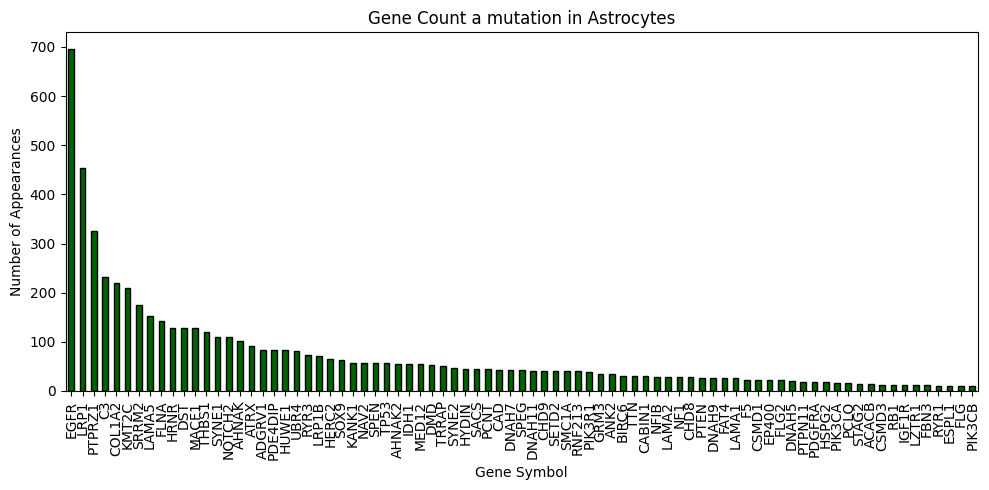

In [43]:
gene_counts = adata_astrocytes_filtered.var["gene_symbol"].value_counts()

print(f"Number of variants: {len(adata_astrocytes)}")
print(f"Number of genes: {len(gene_counts)}")


plt.figure(figsize=(10, 5))
gene_counts_filtered = gene_counts[gene_counts > 10]
gene_counts_filtered.plot(kind="bar", color="darkgreen", edgecolor="black")

plt.ylabel("Number of Appearances")
plt.xlabel("Gene Symbol")
plt.title("Gene Count a mutation in Astrocytes")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [53]:
adata_astrocytes_filtered.var.sort_values(by="VAF_neoplastic_astrocyte_to_VAF_healthy_astrocyte_ratio_1p", ascending=False)

,variant_name,gene_symbol,variant_count,gene_count,number_obs,VAF,seq_ID,mutation_cdna,nucleotide_positions,actual_variant,start_variant_position,end_variant_position,gene_id,variant_name_with_gene_id,variant_name_with_gene_name,TUMOUR_TYPES_SOMATIC,TUMOUR_TYPES_GERMLINE,ROLE_IN_CANCER,number_obs_neoplastic_astrocyte,number_obs_healthy_astrocyte,VAF_neoplastic_astrocyte,VAF_healthy_astrocyte,VAF_neoplastic_astrocyte_to_VAF_healthy_astrocyte_ratio,number_obs_neoplastic_astrocyte_1p,number_obs_healthy_astrocyte_1p,VAF_neoplastic_astrocyte_1p,VAF_healthy_astrocyte_1p,VAF_neoplastic_astrocyte_to_VAF_healthy_astrocyte_ratio_1p
31461,ENST00000245907:c.1005G>A,C3,54420.0,692,466,0.129841,ENST00000245907,c.1005G>A,1005,G>A,1005.0,1005.0,ENSG00000125730,ENSG00000125730(ENST00000245907):c.1005G>A,C3(ENST00000245907):c.1005G>A,NaN,NaN,NaN,151,0,0.138405,0.000000,inf,152,1,0.139322,0.011364,12.260312
261352,ENST00000297268:c.2116C>G,COL1A2,3906.0,304,163,0.045417,ENST00000297268,c.2116C>G,2116,C>G,2116.0,2116.0,ENSG00000164692,ENSG00000164692(ENST00000297268):c.2116C>G,COL1A2(ENST00000297268):c.2116C>G,NaN,NaN,NaN,142,0,0.130156,0.000000,inf,143,1,0.131072,0.011364,11.534372
223247,ENST00000260356:c.1732A>G,THBS1,51535.0,298,548,0.152689,ENST00000260356,c.1732A>G,1732,A>G,1732.0,1732.0,ENSG00000137801,ENSG00000137801(ENST00000260356):c.1732A>G,THBS1(ENST00000260356):c.1732A>G,NaN,NaN,NaN,123,0,0.112741,0.000000,inf,124,1,0.113657,0.011364,10.001833
223380,ENST00000260356:c.1575C>T,THBS1,39030.0,298,538,0.149902,ENST00000260356,c.1575C>T,1575,C>T,1575.0,1575.0,ENSG00000137801,ENSG00000137801(ENST00000260356):c.1575C>T,THBS1(ENST00000260356):c.1575C>T,NaN,NaN,NaN,121,0,0.110907,0.000000,inf,122,1,0.111824,0.011364,9.840513
223246,ENST00000260356:c.1455G>A,THBS1,19158.0,298,186,0.051825,ENST00000260356,c.1455G>A,1455,G>A,1455.0,1455.0,ENSG00000137801,ENSG00000137801(ENST00000260356):c.1455G>A,THBS1(ENST00000260356):c.1455G>A,NaN,NaN,NaN,116,0,0.106324,0.000000,inf,117,1,0.107241,0.011364,9.437214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11343,ENST00000405460:c.3237A>G,ADGRV1,212.0,84,7,0.00195,ENST00000405460,c.3237A>G,3237,A>G,3237.0,3237.0,ENSG00000164199,ENSG00000164199(ENST00000405460):c.3237A>G,ADGRV1(ENST00000405460):c.3237A>G,NaN,NaN,NaN,0,7,0.000000,0.079545,0.000000,1,8,0.000917,0.090909,0.010082
11339,ENST00000405460:c.7302G>A,ADGRV1,1270.0,84,35,0.009752,ENST00000405460,c.7302G>A,7302,G>A,7302.0,7302.0,ENSG00000164199,ENSG00000164199(ENST00000405460):c.7302G>A,ADGRV1(ENST00000405460):c.7302G>A,NaN,NaN,NaN,3,32,0.002750,0.363636,0.007562,4,33,0.003666,0.375000,0.009777
11337,ENST00000405460:c.3287A>C,ADGRV1,133.0,84,9,0.002508,ENST00000405460,c.3287A>C,3287,A>C,3287.0,3287.0,ENSG00000164199,ENSG00000164199(ENST00000405460):c.3287A>C,ADGRV1(ENST00000405460):c.3287A>C,NaN,NaN,NaN,0,9,0.000000,0.102273,0.000000,1,10,0.000917,0.113636,0.008066
11378,ENST00000405460:c.7130A>G,ADGRV1,453.0,84,18,0.005015,ENST00000405460,c.7130A>G,7130,A>G,7130.0,7130.0,ENSG00000164199,ENSG00000164199(ENST00000405460):c.7130A>G,ADGRV1(ENST00000405460):c.7130A>G,NaN,NaN,NaN,0,18,0.000000,0.204545,0.000000,1,19,0.000917,0.215909,0.004245


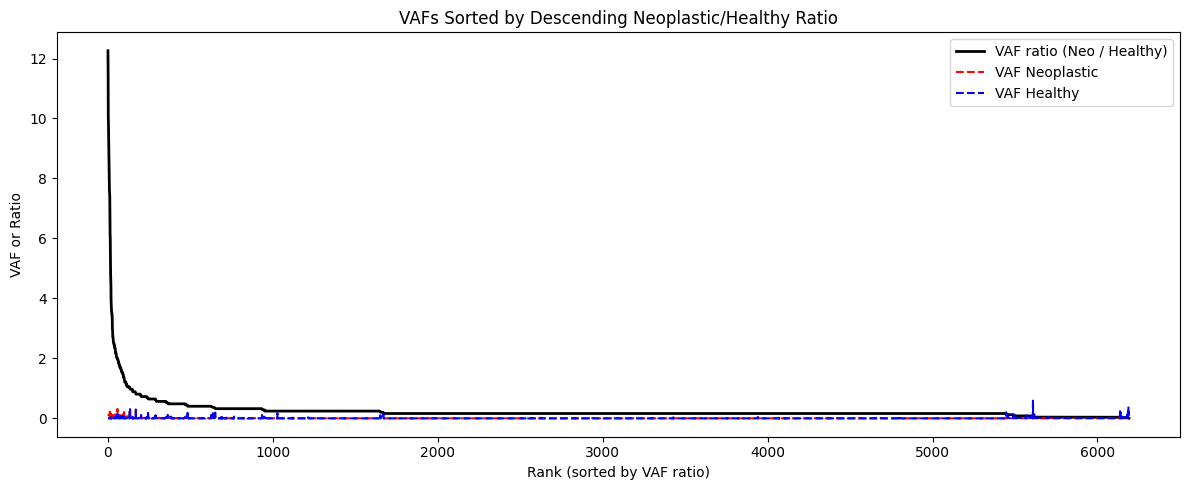

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Get a DataFrame of all three VAFs, dropping NaNs
df = adata_astrocytes_filtered.var[[
    "VAF_neoplastic_astrocyte_to_VAF_healthy_astrocyte_ratio_1p",
    "VAF_neoplastic_astrocyte",
    "VAF_healthy_astrocyte"
]].dropna()

# Sort by ratio descending
df_sorted = df.sort_values(by="VAF_neoplastic_astrocyte_to_VAF_healthy_astrocyte_ratio_1p", ascending=False)

# Extract values
ratios_sorted = df_sorted["VAF_neoplastic_astrocyte_to_VAF_healthy_astrocyte_ratio_1p"].values
neoplastic_sorted = df_sorted["VAF_neoplastic_astrocyte"].values
healthy_sorted = df_sorted["VAF_healthy_astrocyte"].values

# Plot
plt.figure(figsize=(12, 5))
plt.plot(ratios_sorted, label="VAF ratio (Neo / Healthy)", color="black", linewidth=2)
plt.plot(neoplastic_sorted, label="VAF Neoplastic", color="red", linestyle="--")
plt.plot(healthy_sorted, label="VAF Healthy", color="blue", linestyle="--")

plt.xlabel("Rank (sorted by VAF ratio)")
plt.ylabel("VAF or Ratio")
plt.title("VAFs Sorted by Descending Neoplastic/Healthy Ratio")
plt.legend()
plt.tight_layout()
plt.show()


In [45]:
# Get a DataFrame of all three VAFs, dropping NaNs
df2 = adata_astrocytes_filtered.var.dropna()

# Sort by ratio descending
df_sorted2 = df2.sort_values(by="VAF_neoplastic_astrocyte_to_VAF_healthy_astrocyte_ratio_1p", ascending=False)
df_sorted2

,variant_name,gene_symbol,variant_count,gene_count,number_obs,VAF,seq_ID,mutation_cdna,nucleotide_positions,actual_variant,start_variant_position,end_variant_position,gene_id,variant_name_with_gene_id,variant_name_with_gene_name,TUMOUR_TYPES_SOMATIC,TUMOUR_TYPES_GERMLINE,ROLE_IN_CANCER,number_obs_neoplastic_astrocyte,number_obs_healthy_astrocyte,VAF_neoplastic_astrocyte,VAF_healthy_astrocyte,VAF_neoplastic_astrocyte_to_VAF_healthy_astrocyte_ratio,number_obs_neoplastic_astrocyte_1p,number_obs_healthy_astrocyte_1p,VAF_neoplastic_astrocyte_1p,VAF_healthy_astrocyte_1p,VAF_neoplastic_astrocyte_to_VAF_healthy_astrocyte_ratio_1p
358092,ENST00000275493:c.1782C>T,EGFR,157.0,703,45,0.012538,ENST00000275493,c.1782C>T,1782,C>T,1782.0,1782.0,ENSG00000146648,ENSG00000146648(ENST00000275493):c.1782C>T,EGFR(ENST00000275493):c.1782C>T,"glioma, NSCLC",NSCLC,oncogene,44,0,0.040330,0.000000,inf,45,1,0.041247,0.011364,3.629698
358038,ENST00000275493:c.2348G>A,EGFR,129.0,703,47,0.013096,ENST00000275493,c.2348G>A,2348,G>A,2348.0,2348.0,ENSG00000146648,ENSG00000146648(ENST00000275493):c.2348G>A,EGFR(ENST00000275493):c.2348G>A,"glioma, NSCLC",NSCLC,oncogene,43,0,0.039413,0.000000,inf,44,1,0.040330,0.011364,3.549038
226793,ENST00000269305:c.986G>C,TP53,336.0,74,40,0.011145,ENST00000269305,c.986G>C,986,G>C,986.0,986.0,ENSG00000141510,ENSG00000141510(ENST00000269305):c.986G>C,TP53(ENST00000269305):c.986G>C,"breast, colorectal, lung, sarcoma, prostate, a...","breast, sarcoma, adrenocortical carcinoma, gli...","oncogene, TSG, fusion",40,0,0.036664,0.000000,inf,41,1,0.037580,0.011364,3.307058
357653,ENST00000275493:c.1608G>A,EGFR,539.0,703,37,0.010309,ENST00000275493,c.1608G>A,1608,G>A,1608.0,1608.0,ENSG00000146648,ENSG00000146648(ENST00000275493):c.1608G>A,EGFR(ENST00000275493):c.1608G>A,"glioma, NSCLC",NSCLC,oncogene,36,0,0.032997,0.000000,inf,37,1,0.033914,0.011364,2.984418
357937,ENST00000275493:c.2557C>T,EGFR,132.0,703,33,0.009195,ENST00000275493,c.2557C>T,2557,C>T,2557.0,2557.0,ENSG00000146648,ENSG00000146648(ENST00000275493):c.2557C>T,EGFR(ENST00000275493):c.2557C>T,"glioma, NSCLC",NSCLC,oncogene,33,0,0.030247,0.000000,inf,34,1,0.031164,0.011364,2.742438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357740,ENST00000275493:c.1165G>A,EGFR,4.0,703,1,0.000279,ENST00000275493,c.1165G>A,1165,G>A,1165.0,1165.0,ENSG00000146648,ENSG00000146648(ENST00000275493):c.1165G>A,EGFR(ENST00000275493):c.1165G>A,"glioma, NSCLC",NSCLC,oncogene,0,1,0.000000,0.011364,0.0,1,2,0.000917,0.022727,0.040330
358045,ENST00000275493:c.3439C>T,EGFR,10.0,703,1,0.000279,ENST00000275493,c.3439C>T,3439,C>T,3439.0,3439.0,ENSG00000146648,ENSG00000146648(ENST00000275493):c.3439C>T,EGFR(ENST00000275493):c.3439C>T,"glioma, NSCLC",NSCLC,oncogene,0,1,0.000000,0.011364,0.0,1,2,0.000917,0.022727,0.040330
357787,ENST00000275493:c.2434C>T,EGFR,2.0,703,1,0.000279,ENST00000275493,c.2434C>T,2434,C>T,2434.0,2434.0,ENSG00000146648,ENSG00000146648(ENST00000275493):c.2434C>T,EGFR(ENST00000275493):c.2434C>T,"glioma, NSCLC",NSCLC,oncogene,0,1,0.000000,0.011364,0.0,1,2,0.000917,0.022727,0.040330
357932,ENST00000275493:c.1567T>C,EGFR,2.0,703,1,0.000279,ENST00000275493,c.1567T>C,1567,T>C,1567.0,1567.0,ENSG00000146648,ENSG00000146648(ENST00000275493):c.1567T>C,EGFR(ENST00000275493):c.1567T>C,"glioma, NSCLC",NSCLC,oncogene,0,1,0.000000,0.011364,0.0,1,2,0.000917,0.022727,0.040330


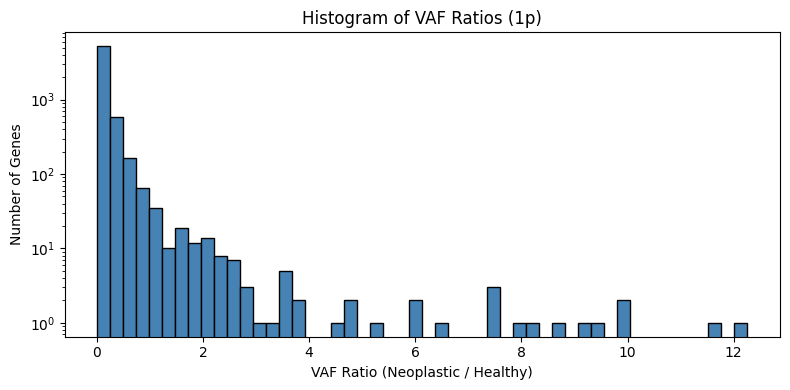

In [48]:
plt.figure(figsize=(8, 4))
plt.hist(ratios_sorted, bins=50, color='steelblue', edgecolor='black')
plt.xlabel("VAF Ratio (Neoplastic / Healthy)")
plt.ylabel("Number of Genes")
# plt.xscale('log')
plt.yscale('log')
plt.title("Histogram of VAF Ratios (1p)")
plt.tight_layout()
plt.show()

Number of variants with VAF ratio >= 2.1: 51
Number of genes with VAF ratio >= 2.1: 13


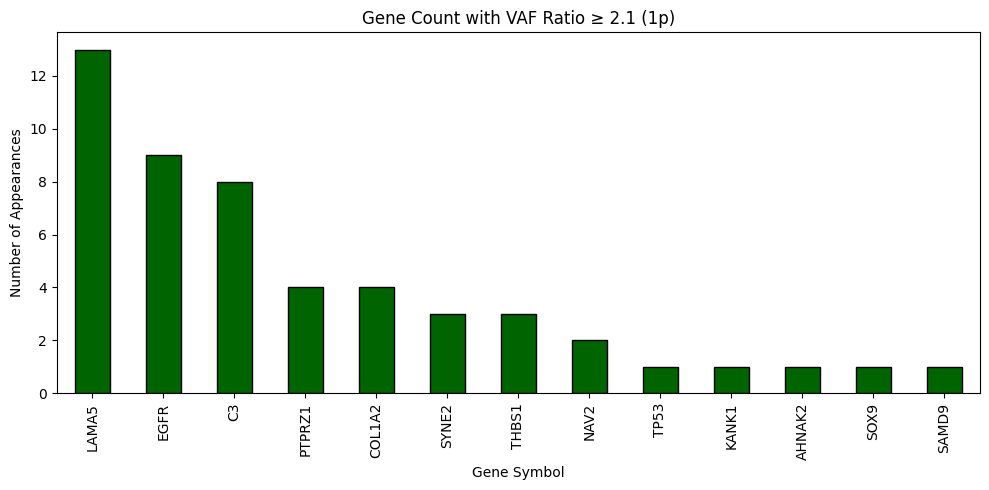

In [54]:
VAF_ratio_cutoff = 2.1

# Step 1: Filter
filtered_df = adata_astrocytes.var[
    adata_astrocytes.var["VAF_neoplastic_astrocyte_to_VAF_healthy_astrocyte_ratio_1p"] >= VAF_ratio_cutoff
]

# Step 2: Count gene_symbol occurrences
gene_counts = filtered_df["gene_symbol"].value_counts()

print(f"Number of variants with VAF ratio >= {VAF_ratio_cutoff}: {len(filtered_df)}")
print(f"Number of genes with VAF ratio >= {VAF_ratio_cutoff}: {len(gene_counts)}")

# Step 3: Sort descending (already sorted by default from value_counts)

# Step 4: Bar plot
plt.figure(figsize=(10, 5))
gene_counts.plot(kind="bar", color="darkgreen", edgecolor="black")

plt.ylabel("Number of Appearances")
plt.xlabel("Gene Symbol")
plt.title(f"Gene Count with VAF Ratio ≥ {VAF_ratio_cutoff} (1p)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [34]:
filtered_df

,variant_name,gene_symbol,variant_count,gene_count,number_obs,VAF,seq_ID,mutation_cdna,nucleotide_positions,actual_variant,start_variant_position,end_variant_position,gene_id,variant_name_with_gene_id,variant_name_with_gene_name,TUMOUR_TYPES_SOMATIC,TUMOUR_TYPES_GERMLINE,ROLE_IN_CANCER,number_obs_neoplastic_astrocyte,number_obs_healthy_astrocyte,VAF_neoplastic_astrocyte,VAF_healthy_astrocyte,VAF_neoplastic_astrocyte_to_VAF_healthy_astrocyte_ratio,number_obs_neoplastic_astrocyte_1p,number_obs_healthy_astrocyte_1p,VAF_neoplastic_astrocyte_1p,VAF_healthy_astrocyte_1p,VAF_neoplastic_astrocyte_to_VAF_healthy_astrocyte_ratio_1p
13567,ENST00000367255:c.10097A>G,SYNE1,1763.0,192,89,0.024798,ENST00000367255,c.10097A>G,10097,A>G,10097.0,10097.0,ENSG00000131018,ENSG00000131018(ENST00000367255):c.10097A>G,SYNE1(ENST00000367255):c.10097A>G,NaN,NaN,NaN,44,1,0.040330,0.011364,3.549038,45,2,0.041247,0.022727,1.814849
15674,ENST00000393386:c.4709G>A,PTPRZ1,1927.0,427,201,0.056004,ENST00000393386,c.4709G>A,4709,G>A,4709.0,4709.0,ENSG00000106278,ENSG00000106278(ENST00000393386):c.4709G>A,PTPRZ1(ENST00000393386):c.4709G>A,NaN,NaN,NaN,148,1,0.135655,0.011364,11.937672,149,2,0.136572,0.022727,6.009166
15731,ENST00000393386:c.6167C>T,PTPRZ1,89.0,427,29,0.00808,ENST00000393386,c.6167C>T,6167,C>T,6167.0,6167.0,ENSG00000106278,ENSG00000106278(ENST00000393386):c.6167C>T,PTPRZ1(ENST00000393386):c.6167C>T,NaN,NaN,NaN,22,0,0.020165,0.000000,inf,23,1,0.021082,0.011364,1.855179
15743,ENST00000393386:c.419T>G,PTPRZ1,10327.0,427,266,0.074115,ENST00000393386,c.419T>G,419,T>G,419.0,419.0,ENSG00000106278,ENSG00000106278(ENST00000393386):c.419T>G,PTPRZ1(ENST00000393386):c.419T>G,NaN,NaN,NaN,241,2,0.220898,0.022727,9.719523,242,3,0.221815,0.034091,6.506569
15745,ENST00000393386:c.4561G>A,PTPRZ1,611.0,427,29,0.00808,ENST00000393386,c.4561G>A,4561,G>A,4561.0,4561.0,ENSG00000106278,ENSG00000106278(ENST00000393386):c.4561G>A,PTPRZ1(ENST00000393386):c.4561G>A,NaN,NaN,NaN,29,0,0.026581,0.000000,inf,30,1,0.027498,0.011364,2.419798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358257,ENST00000275493:c.1042G>A,EGFR,754.0,703,20,0.005573,ENST00000275493,c.1042G>A,1042,G>A,1042.0,1042.0,ENSG00000146648,ENSG00000146648(ENST00000275493):c.1042G>A,EGFR(ENST00000275493):c.1042G>A,"glioma, NSCLC",NSCLC,oncogene,20,0,0.018332,0.000000,inf,21,1,0.019248,0.011364,1.693859
358682,ENST00000379958:c.1230T>C,SAMD9,355.0,18,47,0.013096,ENST00000379958,c.1230T>C,1230,T>C,1230.0,1230.0,ENSG00000205413,ENSG00000205413(ENST00000379958):c.1230T>C,SAMD9(ENST00000379958):c.1230T>C,NaN,NaN,NaN,28,0,0.025665,0.000000,inf,29,1,0.026581,0.011364,2.339138
392504,ENST00000393386:c.4701_4703del,PTPRZ1,344.0,427,95,0.02647,ENST00000393386,c.4701_4703del,4701_4703,del,4701.0,4703.0,ENSG00000106278,ENSG00000106278(ENST00000393386):c.4701_4703del,PTPRZ1(ENST00000393386):c.4701_4703del,NaN,NaN,NaN,58,2,0.053162,0.022727,2.339138,59,3,0.054079,0.034091,1.586312
392506,ENST00000393386:c.554del,PTPRZ1,895.0,427,64,0.017832,ENST00000393386,c.554del,554,del,554.0,554.0,ENSG00000106278,ENSG00000106278(ENST00000393386):c.554del,PTPRZ1(ENST00000393386):c.554del,NaN,NaN,NaN,48,1,0.043996,0.011364,3.871677,49,2,0.044913,0.022727,1.976169


In [32]:
adata_astrocytes.var.sort_values(
    by="VAF_neoplastic_astrocyte_to_VAF_healthy_astrocyte_ratio_1p",
    ascending=False
)

,variant_name,gene_symbol,variant_count,gene_count,number_obs,VAF,seq_ID,mutation_cdna,nucleotide_positions,actual_variant,start_variant_position,end_variant_position,gene_id,variant_name_with_gene_id,variant_name_with_gene_name,TUMOUR_TYPES_SOMATIC,TUMOUR_TYPES_GERMLINE,ROLE_IN_CANCER,number_obs_neoplastic_astrocyte,number_obs_healthy_astrocyte,VAF_neoplastic_astrocyte,VAF_healthy_astrocyte,VAF_neoplastic_astrocyte_to_VAF_healthy_astrocyte_ratio,number_obs_neoplastic_astrocyte_1p,number_obs_healthy_astrocyte_1p,VAF_neoplastic_astrocyte_1p,VAF_healthy_astrocyte_1p,VAF_neoplastic_astrocyte_to_VAF_healthy_astrocyte_ratio_1p
31461,ENST00000245907:c.1005G>A,C3,54420.0,692,466,0.129841,ENST00000245907,c.1005G>A,1005,G>A,1005.0,1005.0,ENSG00000125730,ENSG00000125730(ENST00000245907):c.1005G>A,C3(ENST00000245907):c.1005G>A,NaN,NaN,NaN,151,0,0.138405,0.000000,inf,152,1,0.139322,0.011364,12.260312
261352,ENST00000297268:c.2116C>G,COL1A2,3906.0,304,163,0.045417,ENST00000297268,c.2116C>G,2116,C>G,2116.0,2116.0,ENSG00000164692,ENSG00000164692(ENST00000297268):c.2116C>G,COL1A2(ENST00000297268):c.2116C>G,NaN,NaN,NaN,142,0,0.130156,0.000000,inf,143,1,0.131072,0.011364,11.534372
223247,ENST00000260356:c.1732A>G,THBS1,51535.0,298,548,0.152689,ENST00000260356,c.1732A>G,1732,A>G,1732.0,1732.0,ENSG00000137801,ENSG00000137801(ENST00000260356):c.1732A>G,THBS1(ENST00000260356):c.1732A>G,NaN,NaN,NaN,123,0,0.112741,0.000000,inf,124,1,0.113657,0.011364,10.001833
223380,ENST00000260356:c.1575C>T,THBS1,39030.0,298,538,0.149902,ENST00000260356,c.1575C>T,1575,C>T,1575.0,1575.0,ENSG00000137801,ENSG00000137801(ENST00000260356):c.1575C>T,THBS1(ENST00000260356):c.1575C>T,NaN,NaN,NaN,121,0,0.110907,0.000000,inf,122,1,0.111824,0.011364,9.840513
223246,ENST00000260356:c.1455G>A,THBS1,19158.0,298,186,0.051825,ENST00000260356,c.1455G>A,1455,G>A,1455.0,1455.0,ENSG00000137801,ENSG00000137801(ENST00000260356):c.1455G>A,THBS1(ENST00000260356):c.1455G>A,NaN,NaN,NaN,116,0,0.106324,0.000000,inf,117,1,0.107241,0.011364,9.437214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11343,ENST00000405460:c.3237A>G,ADGRV1,212.0,84,7,0.00195,ENST00000405460,c.3237A>G,3237,A>G,3237.0,3237.0,ENSG00000164199,ENSG00000164199(ENST00000405460):c.3237A>G,ADGRV1(ENST00000405460):c.3237A>G,NaN,NaN,NaN,0,7,0.000000,0.079545,0.000000,1,8,0.000917,0.090909,0.010082
11339,ENST00000405460:c.7302G>A,ADGRV1,1270.0,84,35,0.009752,ENST00000405460,c.7302G>A,7302,G>A,7302.0,7302.0,ENSG00000164199,ENSG00000164199(ENST00000405460):c.7302G>A,ADGRV1(ENST00000405460):c.7302G>A,NaN,NaN,NaN,3,32,0.002750,0.363636,0.007562,4,33,0.003666,0.375000,0.009777
11337,ENST00000405460:c.3287A>C,ADGRV1,133.0,84,9,0.002508,ENST00000405460,c.3287A>C,3287,A>C,3287.0,3287.0,ENSG00000164199,ENSG00000164199(ENST00000405460):c.3287A>C,ADGRV1(ENST00000405460):c.3287A>C,NaN,NaN,NaN,0,9,0.000000,0.102273,0.000000,1,10,0.000917,0.113636,0.008066
11378,ENST00000405460:c.7130A>G,ADGRV1,453.0,84,18,0.005015,ENST00000405460,c.7130A>G,7130,A>G,7130.0,7130.0,ENSG00000164199,ENSG00000164199(ENST00000405460):c.7130A>G,ADGRV1(ENST00000405460):c.7130A>G,NaN,NaN,NaN,0,18,0.000000,0.204545,0.000000,1,19,0.000917,0.215909,0.004245


# Histograms

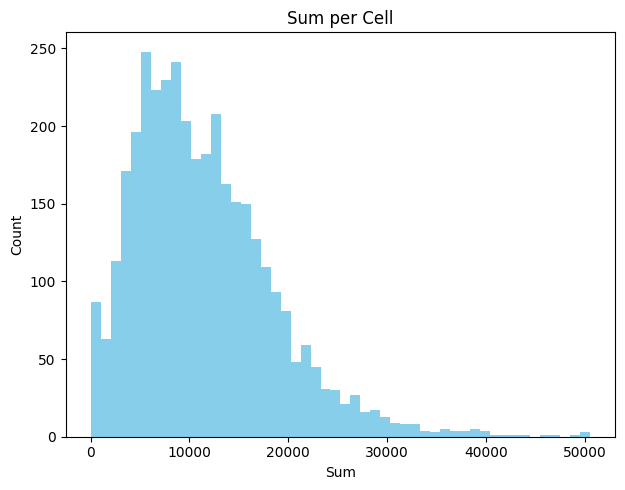

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Sum across rows (per cell)
row_sums = adata.X.sum(axis=1).A1 if hasattr(adata.X, "A1") else np.ravel(adata.X.sum(axis=1))

# Sum across columns (per gene)
col_sums = adata.X.sum(axis=0).A1 if hasattr(adata.X, "A1") else np.ravel(adata.X.sum(axis=0))

# Plot histograms
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(row_sums, bins=50, color='skyblue')
plt.title('Sum per Cell')
plt.xlabel('Sum')
plt.ylabel('Count')

# plt.subplot(1, 2, 2)
# plt.hist(col_sums, bins=50, color='salmon')
# plt.title('Sum per Gene')
# plt.xlabel('Sum')
# plt.ylabel('Count')

plt.tight_layout()
plt.show()


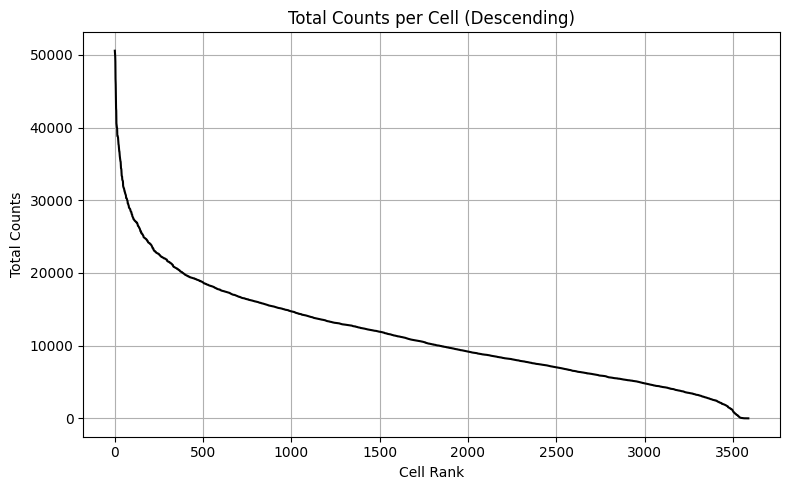

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Compute sum per cell (rows)
row_sums = adata.X.sum(axis=1).A1 if hasattr(adata.X, "A1") else np.ravel(adata.X.sum(axis=1))

# Sort descending
sorted_sums = np.sort(row_sums)[::-1]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(sorted_sums, color='black')
plt.title("Total Counts per Cell (Descending)")
plt.xlabel("Cell Rank")
plt.ylabel("Total Counts")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

## assign oncogene vs tumor suppressor gene - I expect oncogenes to be more prevelant in mutation data

## Calculate VAF in the cancer cells as a way to try to understand which mutations may be most interesting

## Alphafold

In [ ]:
import varseek as vk
import pyfastx

hgvs_list = ["ENST00000245907:c.1005G>A"]  #!!! change with automatic extraction from above
variant_list

cds_fasta = pyfastx.Fasta(sequences_cds, build_index=True)

id_map = {}
for name in cds_fasta.keys():
    clean_id = name.split('.')[0]
    id_map[clean_id] = name

wt_sequence_list_nucleotide = [cds_fasta[id_map[transcript_id]].seq for variant in variant_list for transcript_id, _ in [variant.split(":")]]
variant_sequence_list_nucleotide = vk.build(variants=variant_list, sequences=wt_sequence_list_nucleotide, w=999999, max_ambiguous=None, min_seq_len=0, optimize_flanking_regions=False, remove_seqs_with_wt_kmers=False, required_insertion_overlap_length=0, merge_identical=False, return_variant_output=True)
variant_sequence_list_amino_acid = [vk.utils.translate_sequence(variant_sequence_nucleotide) for variant_sequence_nucleotide in variant_sequence_list_nucleotide]

alphafold_out_dir = os.path.join(out_dir, "alphafold_predictions")
os.makedirs(alphafold_out_dir, exist_ok=True)
for variant, variant_sequence_amino_acid in zip(variant_list, variant_sequence_list_amino_acid):
    transcript_id, variant = variant.split(":")
    row = cosmic_df.loc[cosmic_df["header"] == variant, ["mutation_aa", "mutation"]].iloc[0]
    mutation_aa, variant = row["mutation_aa"], row["mutation"]
    if mutation_aa is None:
        print(f"Mutation {variant} not found in cosmic_df")
    print(f"{variant}: {mutation_aa}")
    
    out_path = os.path.join(alphafold_out_dir, variant)
    gget.alphafold(variant_sequence_amino_acid, out=out_path)

ValueError: variants must be a string, a list of strings, a path to a variant database, or a string specifying a variant database supported by varseek. Got <class 'str'>.
To see a list of internally supported variant databases and reference genomes, please use the 'list_internally_supported_indices' flag/argument.

In [ ]:
# import subprocess

# variant_list = ["ENST00000245907:c.1005G>A"]  #!!! change with automatic extraction from above
# for variant in variant_list:
#     transcript_id, variant = variant.split(":")
#     mutation_aa = cosmic_df.loc[cosmic_df["header"] == variant, "mutation_aa"].values[0]
#     if mutation_aa is None:
#         print(f"Mutation {variant} not found in cosmic_df")
#         continue
#     protein_sequence = subprocess.run(["curl", f'"https://grch37.rest.ensembl.org/sequence/id/{transcript_id}?type=protein', "-H", "Content-Type: text/x-fasta"], check=True, capture_output=True, text=True)
#     if protein_sequence.returncode != 0:
#         print(f"Error fetching protein sequence for {transcript_id}: {protein_sequence.stderr}")
#         continue
#     protein_sequence = protein_sequence.stdout.split("\n")[1:]  # Skip the first line (header)
    
    
#     protein_position = int(re.search(r"(\d+)", mutation_aa[3:]).group(0))  # extract protein_position with regular expression, starting at 3 and ending at last digit
#     amino_acid_original = mutation_aa[2]  # after the "p."
#     amino_acid_final = mutation_aa[-1]
    
#     if amino_acid_final == "*":  # stop codon
#         protein_sequence = protein_sequence[:protein_position - 1]
#     elif 